In [1]:
# imports
import torch
import json
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# figure aesthetics
# plt.style.use(['dark_background','seaborn-notebook'])  # for dark themes
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])
# plt.style.use(['seaborn-notebook'])

In [3]:
root = Path('..')

# custom libraries
import sys, os
sys.path.append(os.path.abspath('../'))
# print(f"{sys.executable = }")

from utils import spaths, dmaps
import sf_nets.models as models
import sf_nets.datasets as datasets
from utils.mpl_utils import coord_grid

# Dataset

In [4]:
name_ds = 'Sin2'

In [5]:
dataset = getattr(datasets, name_ds)
data_path = root / 'data' / name_ds
model_path = root / 'results' / 'models' / name_ds.lower()

## Path

In [6]:
times, path = torch.load(data_path / 'raw' / 'path.pt')
len(path)

800002

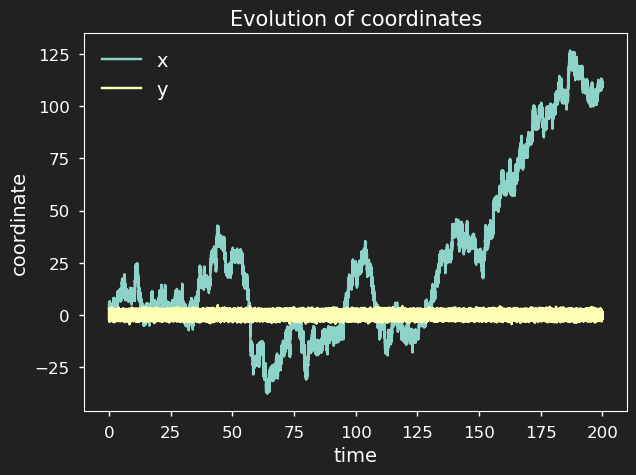

In [7]:
coords = plt.plot(times, path)
plt.xlabel("time")
plt.ylabel("coordinate", rotation=90)
plt.title("Evolution of coordinates")
plt.legend(coords, ("x", "y"))
plt.show()

In [8]:
colors = ['#8dd3c7', '#feffb3', '#fa8174']
cmap1 = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)

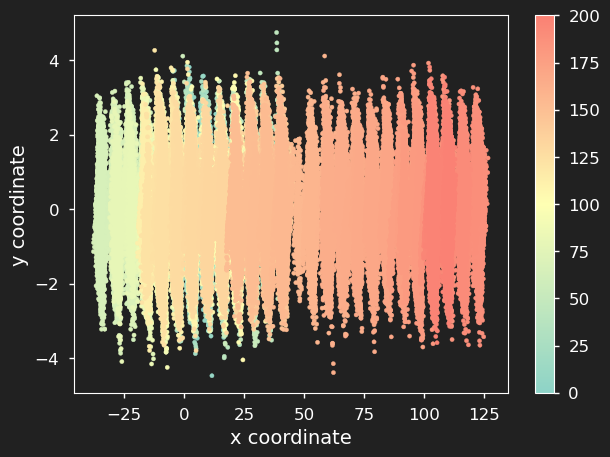

In [9]:
plt.scatter(*path.T, c=times, cmap=cmap1)
plt.xlabel("x coordinate")
plt.ylabel("y coordinate", rotation=90)
plt.colorbar()
plt.show()

## Training dataset

In [10]:
train_ds = dataset(root / 'data')

In [11]:
np.any(train_ds == np.nan)

False

In [12]:
len(train_ds.slow_proj)

2680

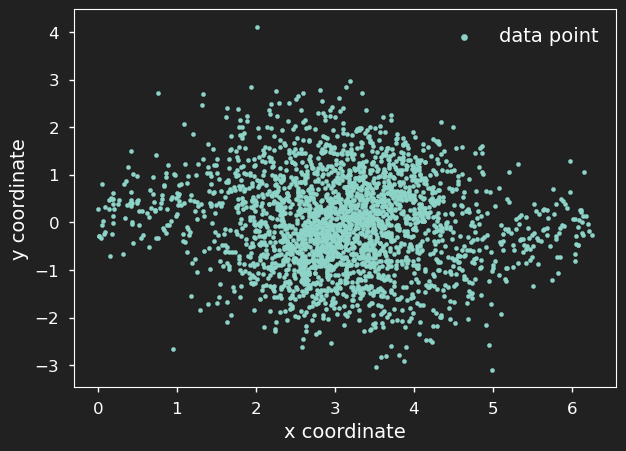

In [13]:
plt.scatter(*train_ds.data.T, label="data point")
plt.xlabel("x coordinate")
plt.ylabel("y coordinate", rotation=90)
plt.legend()
plt.show()

### Timescale spearation

In [14]:
covis = np.array([covi.detach().numpy() for dp, covi, *rest in train_ds])
covis.shape

(2680, 2, 2)

In [15]:
data_evals, data_evecs = zip(*[np.linalg.eigh(covi) for covi in covis])  # zip(*...) is equiv to transposing :)
data_evals, data_evecs = 1/np.array(data_evals), np.array(data_evecs)

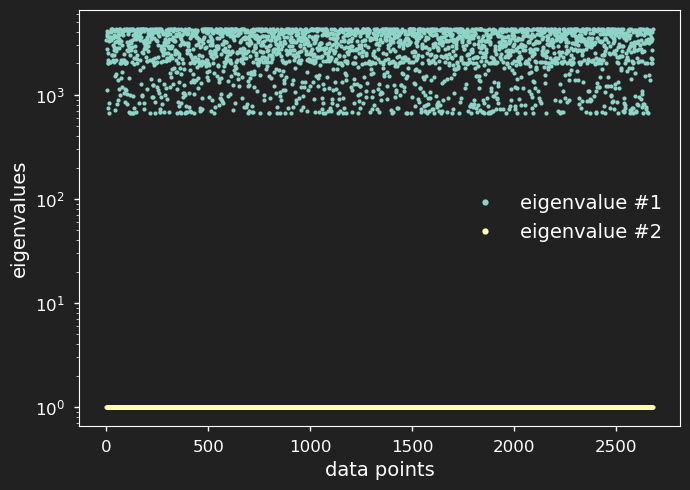

In [16]:
fig, ax = plt.subplots()
for n, e_val in enumerate(data_evals.T):
    ax.plot(e_val/data_evals.T[-1], 'o', label=f"eigenvalue #{n+1}")
ax.legend()
ax.set_yscale('log')

ax.set_xlabel('data points')
ax.set_ylabel('eigenvalues')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Slow manifold

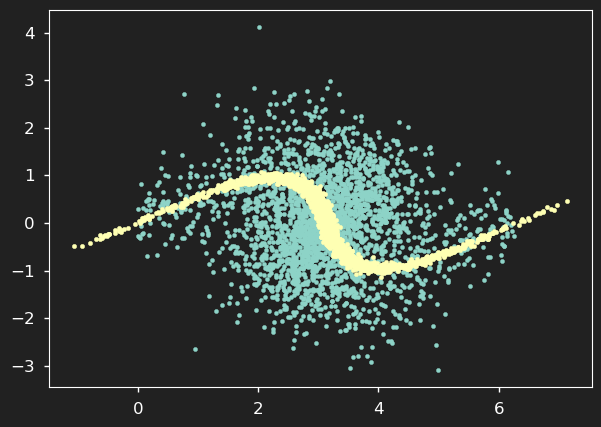

In [17]:
plt.scatter(*train_ds.data.T, label="data point")
plt.scatter(*train_ds.slow_proj.T, s=10, label="slow manifold");

# Trained models

In [18]:
model_types = ['mse', 'mah']

In [266]:
series_list = []
for file in os.listdir(model_path):
    fpath = Path(file)
    if fpath.suffix == '.pt' and any(mt in fpath.stem for mt in model_types):
        model_data = torch.load(model_path / fpath.name)
        par_dict = {
            key:val
            for key, val in model_data['info']['config'].items()
            if key in {'max_epochs'}
        }
#         par_dict['layers (i,l,[h])'] = model_data['state']['best_model_dict'].keys()
#         par_dict['train_size'] = model_data['info']['config']['loader']['train_size']
#         par_dict['valid_size'] = model_data['info']['config']['loader']['valid_size']
        par_dict['features'] = model_data['info'].get('features', [])
        pruning = model_data['info']['config'].get('pruning')
        par_dict['sparsity'] = model_data['best']['sparsity'] if pruning else 0.0
        par_dict['valid_loss'] = model_data['history']['valid_losses'][model_data['best']['epoch']-1]
        par_dict['model_id'] = fpath.stem
        series_list.append(par_dict)
models_df = pd.DataFrame(series_list)
# models_df.set_index('model_id').sort_values(by='model_id')
(
models_df.set_index('model_id')
         .sort_values(by='model_id')
         .style.format({
             'sparsity': '{0:.0%}',
             'valid_loss': '{:.2}',
             'features': lambda x: "{:}".format(list(x)),  # TODO: format with dashes
             'burst_dt': '{:.0e}',
             'burst_size': '{:.0e}'
         })
         .set_properties(**{'font-size': '12pt',})
)

,max_epochs,features,sparsity,valid_loss
model_id,,,,
mah_elu_0,1000,"[2, 4, 1, 4, 2]",0%,0.0055
mah_elu_00,1500,"[2, 3, 1, 3, 2]",0%,0.045
mah_elu_1,2000,"[2, 8, 1, 8, 2]",0%,0.0051
mah_elu_2,3000,"[2, 4, 4, 1, 4, 4, 2]",0%,0.0013
mahl1_elu_0,3000,"[2, 4, 1, 4, 2]",0%,0.096
mahl1_elu_1,3000,"[2, 8, 1, 8, 2]",0%,0.076
mahmse_elu_0,2000,"[2, 4, 1, 4, 2]",0%,0.037
mahmse_elu_0_r1,2000,"[2, 4, 1, 4, 2]",0%,0.092
mse_elu_0,3000,"[2, 4, 1, 4, 2]",0%,0.005


## Loss

In [267]:
model_id = 'mse_elu_00'

In [268]:
model_data = torch.load(model_path /f'{model_id}.pt')
print(f'{model_data.keys() = }')

model_data.keys() = dict_keys(['id', 'info', 'best', 'history'])


In [269]:
train_losses = model_data['history']['train_losses']
valid_losses = model_data['history']['valid_losses']
checkpoints = model_data['history']['checkpoints']
epochs = range(1, model_data['info']['config']['max_epochs']+1)
best_epoch = model_data['best']['epoch']

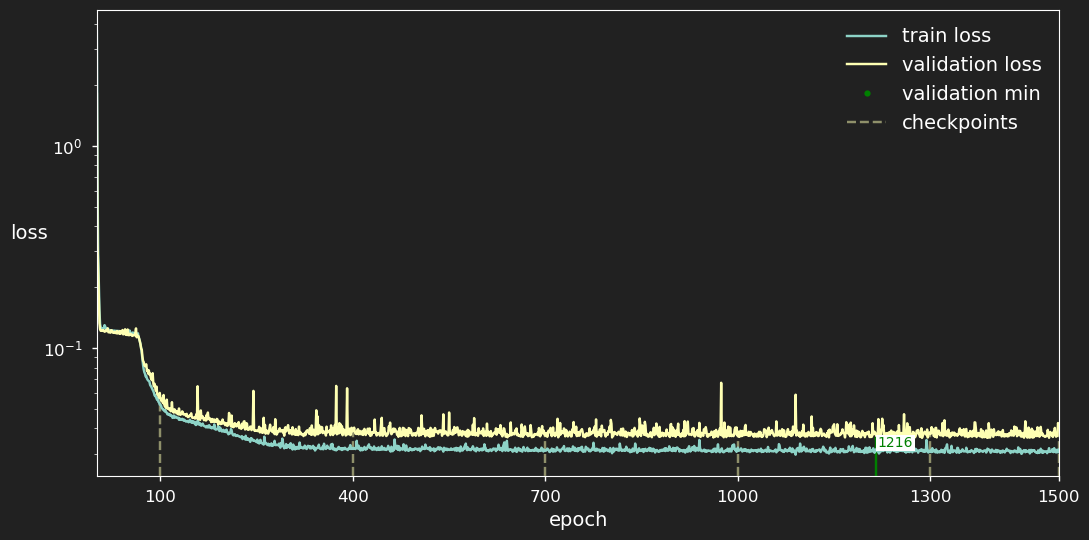

In [270]:
fig, ax = plt.subplots(figsize=(11,5.5))

ax.plot(epochs, train_losses, label="train loss")
loss_line, = ax.plot(epochs, valid_losses, label="validation loss")
loss_color = loss_line.get_color()

# regular checkpoints
check_ids = [check_id for check_id, check_type in checkpoints if check_type != 'best']
check_loss = [valid_losses[idx-1] for idx in check_ids]
plt.vlines(x=check_ids, ymin=0, ymax=check_loss, ls='--', color=loss_color, alpha=0.5, label='checkpoints')

# smallest validation loss / "best" model
smallest_loss = valid_losses[best_epoch-1]
plt.vlines(x=best_epoch, ymin=0, ymax=smallest_loss, color='g')
ax.plot(best_epoch, smallest_loss, 'o', color='g', label='validation min', markersize=3)

ax.text(best_epoch+2, .9*smallest_loss, f'{best_epoch}', rotation=0, color='g', bbox={'fc': 'w', 'ec':'None', 'boxstyle':'Square, pad=0.1'})

ax.set_xlim([epochs[0], epochs[-1]+1])
# ax.set_ylim([0.0, train_losses[1]])
ax.set_xticks(check_ids)
ax.set_xlabel("epoch")
ax.set_ylabel("loss", rotation=0, labelpad=10)
ax.set_yscale('log')
ax.legend()

fig.tight_layout()
fig.savefig(root / f"results/figs/{model_id}_loss.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

## Load Model

In [271]:
model = models.MahalanobisAutoencoder(**model_data['info']['arguments'])
model_dict = 'model_dict'

In [272]:
def remove_mask(model_dict):
    mask_state_dict = dict(filter(lambda elem: elem[0].endswith('_mask'), model_dict.items()))
    orig_state_dict = dict(filter(lambda elem: elem[0].endswith('_orig'), model_dict.items()))
    rest = dict(filter(lambda elem: elem[0].endswith(('weight', 'bias')), model_dict.items()))
    state_dict = {
        key.replace('_orig',''): val_orig * val_mask
        for (key, val_orig), val_mask in zip(orig_state_dict.items(), mask_state_dict.values())
    }
    return {**state_dict, **rest}

In [273]:
check_epoch = 'best'

In [274]:
if check_epoch == 'best':
    state_dict = remove_mask(model_data['best']['model_dict'])
    check_epoch = best_epoch
else:
    check_dict = torch.load(model_path / f'{model_id}' / f'state_at_{check_epoch}.pt')
    state_dict = remove_mask(check_dict['model_dict'])

In [275]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [276]:
model.eval();

## Reconstruction visualization

In [277]:
rec_train_data = model(train_ds.data)
train_data_np = train_ds.data.detach().numpy()
rec_train_data_np = rec_train_data.detach().numpy()

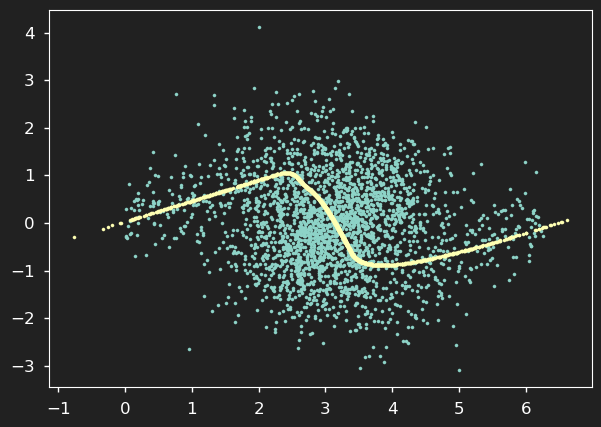

In [278]:
plt.scatter(*train_data_np.T, s=5)
plt.scatter(*rec_train_data_np.T, s=5);

## Encoder accuracy

In [279]:
test_ds = datasets.Sin2(root / 'data', train=False)
test_data_np = test_ds.data.detach().numpy()

In [280]:
# plt.scatter(*test_data_np.T, s=3);

In [281]:
dt = train_ds.dt
sde = train_ds.system
slow_map = train_ds.system.slow_map

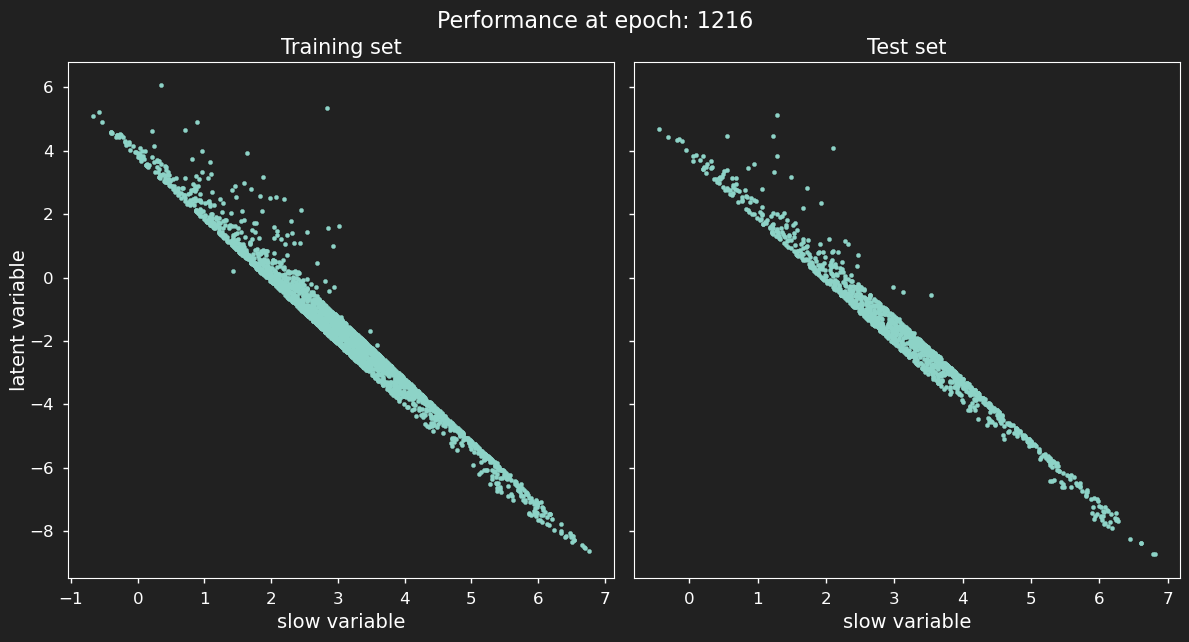

In [282]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6.5), sharey=True)

train_test_data = [train_ds.data, test_ds.data]
for ax, data, title in zip(axs, train_test_data, ['Training set', 'Test set']):
    slow_var = slow_map(data.detach().numpy().T)
    lat_var = model.encoder(data).detach().numpy()
    try:
        ax.scatter(slow_var, lat_var.T)
    except ValueError:
        print('Latent layer too large.')
        plt.close(fig)
    
    ax.set_title(f'{title}')
    ax.set_xlabel('slow variable')
axs[0].set_ylabel('latent variable', labelpad=0)

fig.tight_layout()

fig.suptitle(f'Performance at epoch: {check_epoch}', size=16)
fig.subplots_adjust(top=0.9)
# fig.savefig(root / f"results/figs/{model_id}_slowvar.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

## Encoder: level sets

In [283]:
def to_darray(*meshgrids):
    return np.stack(meshgrids).reshape(len(meshgrids), -1).T

def to_grid(darray, grid_size):
    if darray.ndim == 1:
        return darray.reshape(grid_size, -1)
    else:
        return darray.reshape(darray.shape[1], grid_size, -1)

In [284]:
mesh_size = 400
x = np.linspace(+0.0, 6.0, mesh_size)
y = np.linspace(-3.0, 3.0, mesh_size)

In [285]:
X, Y = np.meshgrid(x, y)

In [286]:
mesh_data = torch.tensor(to_darray(X, Y), dtype=torch.float)
mesh_data.shape

torch.Size([160000, 2])

In [287]:
with torch.no_grad():
    z = model.encoder(mesh_data)
z.size()

torch.Size([160000, 1])

In [288]:
Z = torch.squeeze(to_grid(z, mesh_size))
Z.size()

torch.Size([400, 400])

In [289]:
zz = slow_map(mesh_data.numpy().T).T
ZZ = np.squeeze(to_grid(zz, mesh_size))

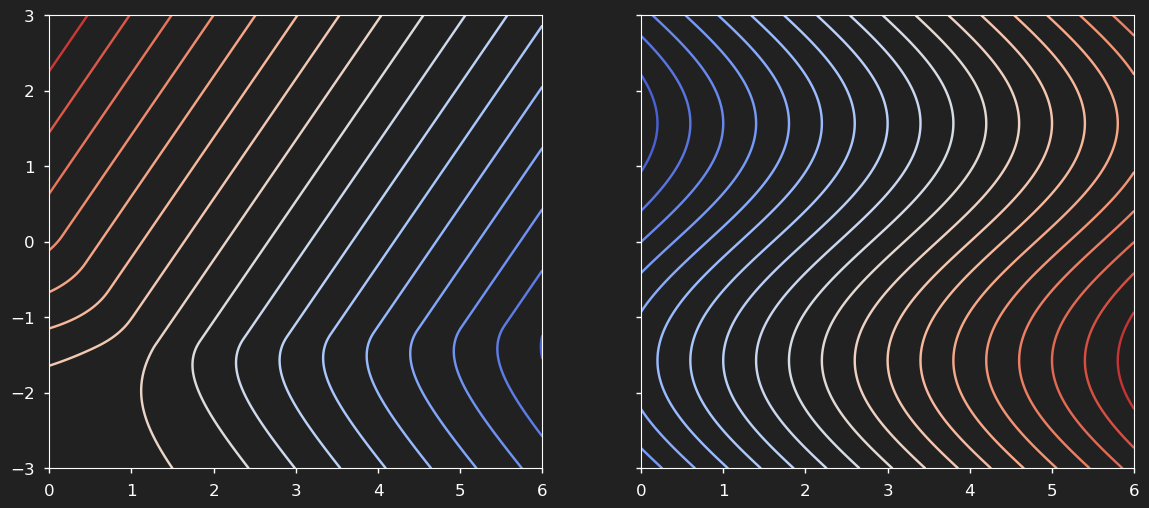

In [290]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharey=True)

cntr = axs[0].contour(X, Y, Z, levels=20)
# fig.colorbar(cntr, ax=ax)

# axs[0].plot(np.sin(3*y)/3, y)

cntr = axs[1].contour(X, Y, ZZ, levels=20)

plt.show()

## Decoder

In [45]:
t = torch.linspace(-6.0, 6.0, 50)[:, None]
t.size()

torch.Size([50, 1])

In [46]:
with torch.no_grad():
    x = model.decoder(t)
x.size()

torch.Size([50, 2])

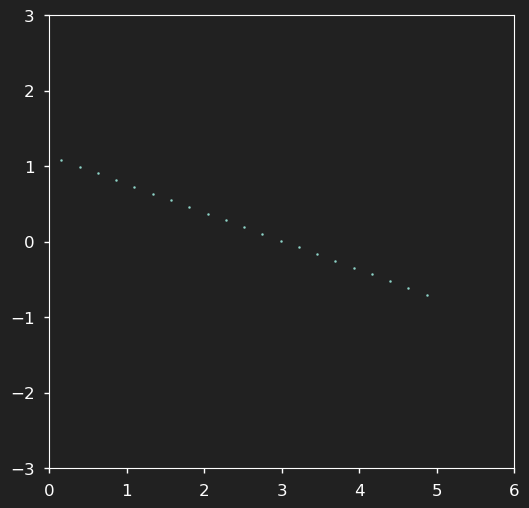

In [47]:
fig = plt.figure(figsize=(6,6))

plt.scatter(*x.T, s=2)

plt.xlim([+0.0, 6.0])
plt.ylim([-3.0, 3.0])

plt.show(fig)
plt.close(fig)

## Variances of bursts

In [48]:
# seed setting and solver
seed = 775
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

sde = train_ds.system

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [49]:
size = 1_000
nreps = 5_000
ndim = train_ds.system.ndim
dt = train_ds.burst_dt / 5 

In [50]:
dp = rng.permutation(test_data_np)[:size]
ens0 = np.repeat(dp, nreps, axis=0)
ens0.shape

(5000000, 2)

In [51]:
bursts = em.burst(sde, ens0, (0, 1), dt).reshape(len(dp), nreps, ndim)
bursts.shape

(1000, 5000, 2)

In [52]:
coords_vars = np.var(bursts, axis=1) / dt
# coords_vars = coords_vars[:, :5]
print(coords_vars.shape)
slow_vars = np.var(slow_map(bursts.T).T, axis=1) / dt
print(slow_vars.shape)

(1000, 2)
(1000, 1)


In [53]:
bursts_t = torch.from_numpy(bursts).to(dtype=torch.float)
with torch.no_grad():
    slow_view = model.encoder(bursts_t).numpy()
slow_view_vars = np.var(slow_view, axis=1) / dt

In [54]:
all_vars = np.hstack([coords_vars, slow_vars, slow_view_vars])
all_vars.shape

(1000, 4)

In [55]:
labs_x = [ f'x{n+1}' for n in range(coords_vars.shape[1]) ]
labs_s = [ f'slow{n+1}' for n in range(slow_vars.shape[1]) ]
labs_l = [ f'view{n+1}' for n in range(slow_view_vars.shape[1]) ]

labels = labs_x + labs_s + labs_l

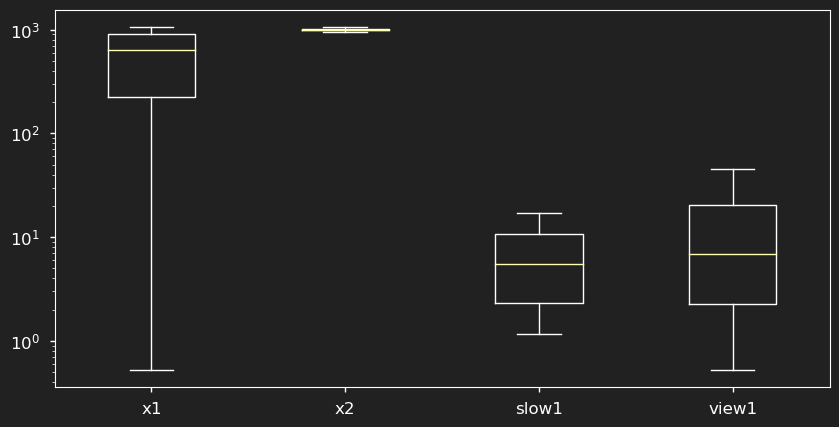

In [56]:
fig, ax = plt.subplots(figsize=(10,5))

ax.boxplot(all_vars, showfliers=False,
            labels=labels);

ax.set_yscale('log')
# plt.boxplot(slow_vars, positions=5);

In [57]:
print(lat_var.shape, slow_var.T.shape)

(1321, 1) (1321, 1)


In [58]:
ls_var = np.hstack([lat_var, slow_var.T])

In [59]:
from sklearn.manifold import SpectralEmbedding

In [60]:
embedding = SpectralEmbedding(n_components=1)

In [61]:
X = embedding.fit_transform(ls_var)
X.shape

(1321, 1)

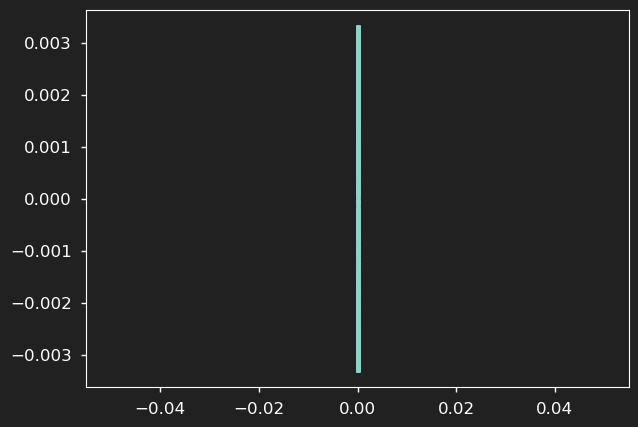

In [62]:
plt.scatter(np.zeros_like(X), X)

## Local directions

In [63]:
def batch_dot(arr_vecs1, arr_vecs2):
    return np.einsum('ij,ij->i', arr_vecs1, arr_vecs2)

In [64]:
idx = 540
burst_size = 1_000
burst_dt = dt / 5
dpt = test_data_np[[idx]]
dpt.shape

(1, 2)

In [65]:
dpt_rep = np.repeat(dpt, burst_size, axis=0)
burst = em.burst(sde, dpt_rep, (0.0, 1), burst_dt)
burst.shape

(1000, 2)

In [66]:
burst_cov = np.cov(burst.T) / burst_dt
burst_avg = np.mean(burst, axis=0, keepdims=True)
burst_avg.shape

(1, 2)

In [67]:
from sklearn.decomposition import PCA

In [68]:
pca = PCA(n_components=2)

In [69]:
pca.fit(burst)

PCA(n_components=2)

In [70]:
print(pca.components_)

[[-0.6777261  -0.73531455]
 [-0.73531455  0.6777261 ]]


Compare with eigenvectors of precomputed covariances: 

In [71]:
test_precs = test_ds.precs

In [72]:
data_evals, data_evecs = zip(*[np.linalg.eigh(prec) for prec in test_precs])  # zip(*...) is equiv to transposing :)
data_evals, data_evecs = 1/np.array(data_evals), np.array(data_evecs)

In [73]:
data_evecs[idx]

array([[-0.67793584, -0.7351211 ],
       [-0.7351211 ,  0.67793584]], dtype=float32)

In [74]:
f_evecs = np.vstack([e_vec[0] for e_vec in data_evecs])
# s_evecs = np.array(s_evecs)
f_evecs.shape

(1321, 2)

Gradients of slow map

In [75]:
test_data_grad = sde.slow_map_grad(test_data_np.T)

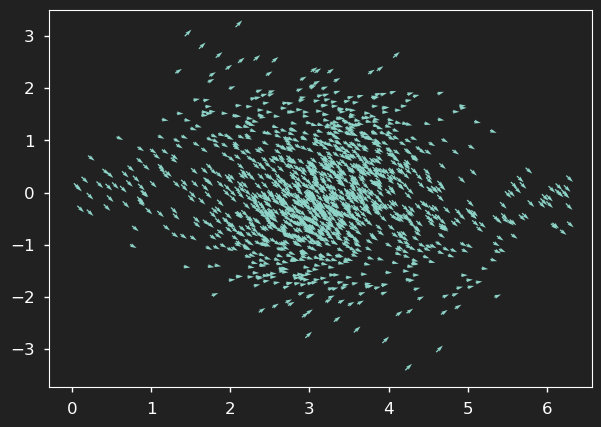

In [76]:
plt.quiver(*test_data_np.T, *test_data_grad, color='C0');

In [77]:
f_evecs_dot_slow_grad = batch_dot(f_evecs, test_data_grad.T)

In [78]:
np.mean(f_evecs_dot_slow_grad), np.var(f_evecs_dot_slow_grad)

(-0.00027161022, 4.835435e-08)

In [79]:
sgrad = sde.slow_map_grad(dpt.T)

In [80]:
sgrad

array([[ 1.       ],
       [-0.9216145]], dtype=float32)

In [81]:
np.dot(pca.components_[0], sgrad)

array([-4.953146e-05], dtype=float32)

In [82]:
np.dot(pca.components_[1], sgrad)

array([-1.3599167], dtype=float32)

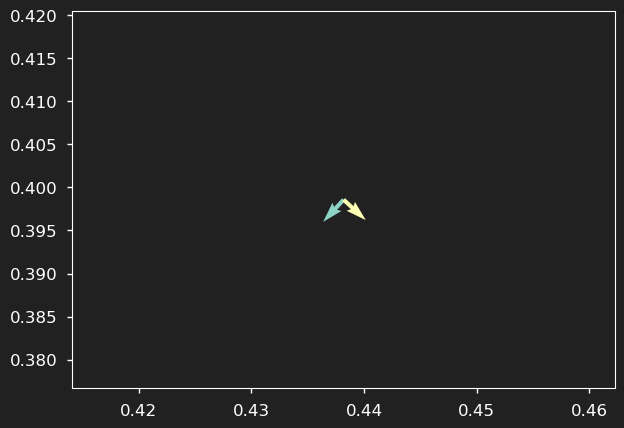

In [83]:
plt.quiver(*dpt.T, *pca.components_[0], color='C0');
plt.quiver(*dpt.T, *sgrad, color='C1');

Encoder grads

In [84]:
dpt_t = torch.from_numpy(dpt).float()

In [85]:
dpt_t.requires_grad_(True)
dpt_t.grad

In [86]:
v = model.encoder(dpt_t)

In [87]:
v.backward()

In [88]:
dpt_t.grad.T

tensor([[-0.8109],
        [ 0.7590]])

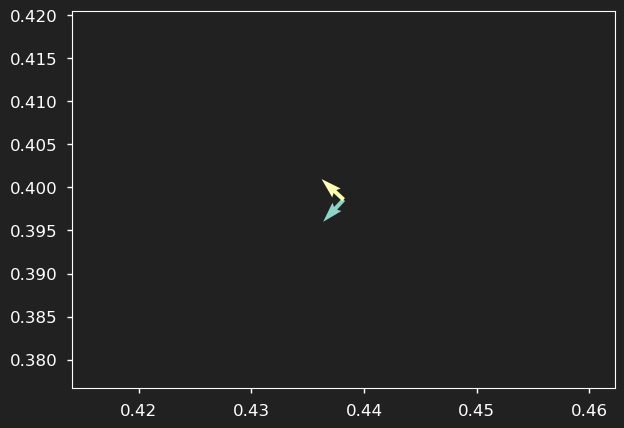

In [89]:
plt.quiver(*dpt.T, *pca.components_[0], color='C0');
plt.quiver(*dpt.T, *dpt_t.grad.T, color='C1');

In [90]:
test_data = test_ds.data
test_data.size()

torch.Size([1321, 2])

In [91]:
test_data.requires_grad_(True)

tensor([[ 2.0677, -0.7328],
        [ 2.2145, -1.6180],
        [ 4.6154,  1.8911],
        ...,
        [ 2.7446,  1.5482],
        [ 3.4918, -0.1020],
        [ 5.6456, -0.4233]], requires_grad=True)

In [92]:
v = model.encoder(test_data)

In [93]:
v.backward(torch.ones_like(v))

In [94]:
grad = test_data.grad / torch.linalg.norm(test_data.grad, dim=1, keepdim=True)

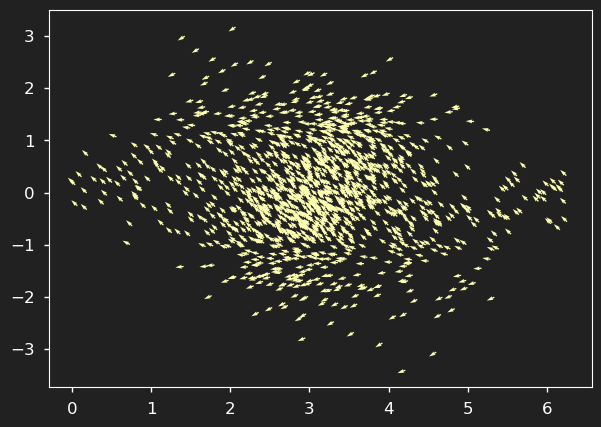

In [95]:
plt.quiver(*test_data_np.T, *grad.T, color='C1');

In [96]:
f_evecs_dot_enc_grad = batch_dot(f_evecs, grad)
np.mean(f_evecs_dot_enc_grad), np.var(f_evecs_dot_enc_grad)

(0.013184122, 0.008946854)